<a href="https://colab.research.google.com/github/tarynduong/DS-projects/blob/main/Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

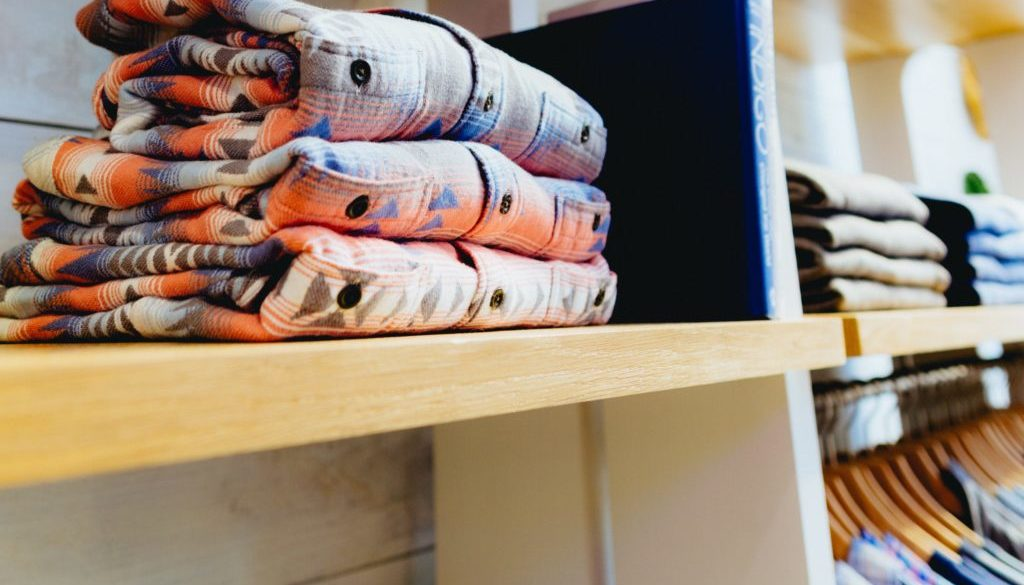

# **README**
## ☁ **Objective**
In a non-contractual setting like ecommerce where customers can make purchases at any time, it is hard to tell exactly how many of customers the company has are active customers since the sales / marketing team do not know timely when they might leave. For lack of churn dates, I will leverage purchase history instead to find out who will be the most valuable customers in the next 3 moths, given some distributional assumptions and probability.
#### **⏩ Problem type:** Probabilistic model
#### **⏩ Experimented model:** Beta-Geometric/Negative Binomial Distribution (BG/NBD) combined with Gamma-Gamma
## 📈 **Sample**
This Online Retail II dataset contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. 

**Attribute information**: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II#

**Source code author**: Duong Minh Truc

# **CODING**

In [23]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) is made specifically for calculating customer lifetime value by Cameron Davidson-Pilon. This Python package is built upon a few assumptions set below:
*   Users interact with you when they are "alive".
*   Users under study may "die" after some period of time.



In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy.stats import poisson
from pandas.api.types import CategoricalDtype

from lifetimes import BetaGeoFitter, GammaGammaFitter

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

## **1. OVERVIEW**
The original file consists of two sheets with the same attributes, so I will group these data into one dataframe.

In [24]:
df = pd.read_excel('online_retail_II.xlsx', sheet_name=['Year 2009-2010', 'Year 2010-2011'])

In [25]:
sales = pd.concat([df['Year 2009-2010'], df['Year 2010-2011']], axis=0, ignore_index=True).reset_index()
sales = sales.iloc[:, 1:]
sales.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


**📖 Data Dictionary**:
* **Invoice**: A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* **StockCode**: A 5-digit integral number uniquely assigned to each distinct product.
* **Customer ID**: A 5-digit integral number uniquely assigned to each customer.



In [26]:
temp = sales[[str(i).startswith('C')==True for i in sales.Invoice]]
temp.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [27]:
temp[temp.Quantity > 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
76799,C496350,M,Manual,1,2010-02-01 08:24:00,373.57,NaN,United Kingdom


It comes with little surprise that quantity is negative for every cancelled record. If that is not the case, the invoice is generated with unknown Customer ID, as observed in this dataset. Anyway, these negative quantity will also be removed as it contributes nothing to the model.

In [28]:
sales = sales[sales.Quantity > 0]

In [29]:
del temp

In [30]:
print('\033[1m                   --- Specification ---        \033[0m')
def report(df):
  print('Size of dataset:', df.shape)
  types = pd.DataFrame(df.dtypes, columns=['data type'])
  missing_value = pd.DataFrame(df.isnull().sum(), columns=['missing values'])
  unique_value = pd.DataFrame(df.nunique(), columns=['unique values'])
  report = types.join(missing_value).join(unique_value)
  return report

report(sales)

                   --- Specification ---        
Size of dataset: (1044421, 8)


,data type,missing values,unique values
Invoice,object,0,41944
StockCode,object,0,4985
Description,object,1693,5469
Quantity,int64,0,564
InvoiceDate,datetime64[ns],0,38429
Price,float64,0,2280
Customer ID,float64,238801,5881
Country,object,0,43


After eliminating records with negative quantity, we now have 5881 unique customers and 38429 invoice dates within the time horizon. Customer ID is mistakenly interpreted as a numerical variable. Let's bring it back to the object type.

In [31]:
sales['Customer ID'] = sales['Customer ID'].astype(object)

In [32]:
sales[sales.isnull().any(axis=1)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
1066997,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066998,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1066999,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
1067000,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


There were 238801 transactions made without identifiable customers. I decided to not keep these records because I neither have sources on which to base to interpolate the Customer ID nor can use Invoice as a dummy customer for each record since this way will dilute the demand patterns and as such, no recognizable trend will be seen.

In [33]:
sales.dropna(subset=['Customer ID'], axis=0, inplace=True)

## **2. EXPLORATORY DATA ANALYSIS**
This part is just an extension for further understanding of the dataset. Maybe that explains why it appears to be a collection of random thoughts backed by facts found accidentally through visualization. And surely, EDA is not that necessary to get the answer for the requirements at hand, which will be done later with statistical models.

**a) England segment dominated the total number of customers within 2 year of span**

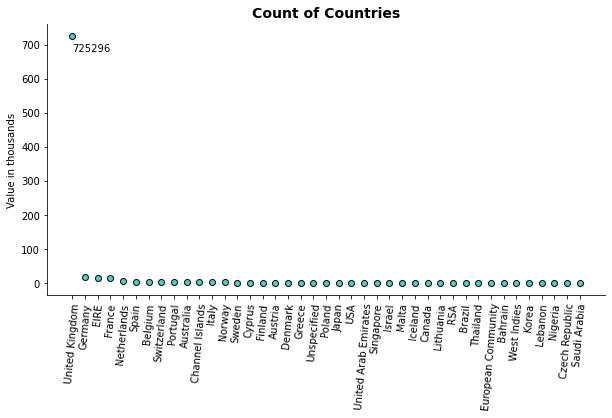

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.scatter(sales.Country.value_counts().index, sales.Country.value_counts(), color='mediumturquoise', edgecolor='black')
plt.xticks(rotation=85)
plt.title('Count of Countries', fontweight='bold', fontsize=14)
ticks_y = FuncFormatter(lambda x, pos:'{0:g}'.format(x/1000))
ax.yaxis.set_major_formatter(ticks_y)
plt.ylabel('Value in thousands')
plt.annotate('725296', (0.01, 680000), color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

**b) Holder and Cake Cases became the top trending products that are in high demand between 2009 and 2011**

In [36]:
def autolabel(chart):
  for element in chart:
    height = element.get_height()
    ax.text(element.get_x() + element.get_width()/2., 1.02*height, '%d' % int(height), ha='center', va='bottom')

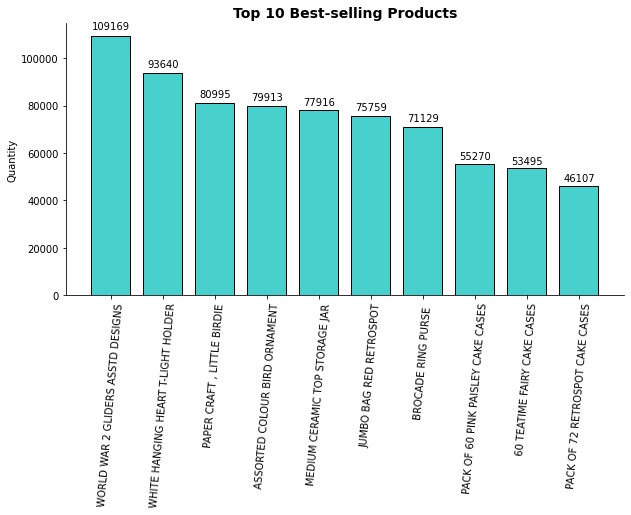

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Top 10 Best-selling Products', fontsize=14, fontweight='bold')

top10 = sales.groupby('Description').sum().sort_values(by='Quantity', ascending=False).head(10)
chart = plt.bar(top10.index, top10.Quantity, width=.75, color='mediumturquoise', edgecolor='black')

plt.ylabel('Quantity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=85)
autolabel(chart)

**c) People tends to buy more on Thursday, in the end of the 1st week and starting of the 3rd week. And it also observed that 2010 is the year with most people going shopping. Most transactions happened in festive seasons.**

In [38]:
temp_df = sales[['Quantity', 'InvoiceDate']].copy()
temp_df['Year'] = temp_df.InvoiceDate.dt.year
temp_df['Quarter'] = temp_df.InvoiceDate.dt.quarter
temp_df['Month'] = temp_df.InvoiceDate.dt.month
temp_df['Day'] = temp_df.InvoiceDate.dt.day
temp_series = []
for i in temp_df.InvoiceDate:
  i = i.strftime('%A')
  temp_series.append(i)
temp_df['DayofWeek'] = temp_series

temp_df.head()

,Quantity,InvoiceDate,Year,Quarter,Month,Day,DayofWeek
0,12,2009-12-01 07:45:00,2009,4,12,1,Tuesday
1,12,2009-12-01 07:45:00,2009,4,12,1,Tuesday
2,12,2009-12-01 07:45:00,2009,4,12,1,Tuesday
3,48,2009-12-01 07:45:00,2009,4,12,1,Tuesday
4,24,2009-12-01 07:45:00,2009,4,12,1,Tuesday


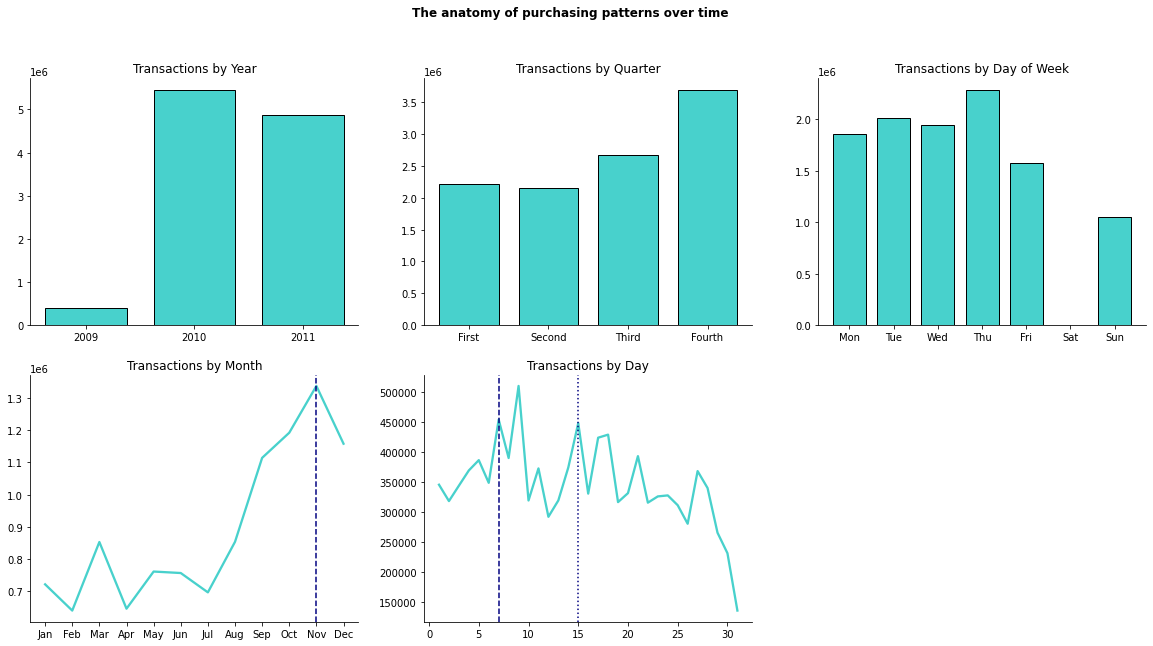

In [39]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
plt.suptitle('The anatomy of purchasing patterns over time', fontweight='bold', fontsize=12)
ax[1, 2].set_visible(False)

temp_year = temp_df.groupby('Year').sum()
temp_quarter = temp_df.groupby('Quarter').sum()
temp_month = temp_df.groupby('Month').sum()
temp_day = temp_df.groupby('Day').sum()
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturnday', 'Sunday'], ordered=True)
temp_df.DayofWeek = temp_df.DayofWeek.astype(cat_type)
temp_dayofweek = temp_df.groupby('DayofWeek').sum()

ax[0, 0].bar(['2009', '2010', '2011'], temp_year.Quantity, width=.75, color='mediumturquoise', edgecolor='black')
ax[0, 0].set_title('Transactions by Year')
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

ax[0, 1].bar(['First', 'Second', 'Third', 'Fourth'], temp_quarter.Quantity, width=.75, color='mediumturquoise', edgecolor='black')
ax[0, 1].set_title('Transactions by Quarter')
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

ax[0, 2].bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], temp_dayofweek.Quantity, width=.75, color='mediumturquoise', edgecolor='black')
ax[0, 2].set_title('Transactions by Day of Week')
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines['right'].set_visible(False)

ax[1, 0].plot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], temp_month.Quantity, color='mediumturquoise', lw=2.3)
ax[1, 0].set_title('Transactions by Month')
ax[1, 0].axvline(10, color='navy', linestyle='--')
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

ax[1, 1].plot(temp_day.index, temp_day.Quantity, color='mediumturquoise', lw=2.3)
ax[1, 1].set_title('Transactions by Day')
ax[1, 1].axvline(7, color='navy', linestyle='--')
ax[1, 1].axvline(15, color='navy', linestyle='dotted')
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)

In [40]:
del temp_df

## **3. PROBABILISTIC MODELS**

In [41]:
sales['Revenue'] = sales.Quantity * sales.Price
model = sales[['Customer ID', 'Invoice', 'InvoiceDate', 'Quantity', 'Price', 'Revenue']].copy()
model.head()

,Customer ID,Invoice,InvoiceDate,Quantity,Price,Revenue
0,13085.0,489434,2009-12-01 07:45:00,12,6.95,83.4
1,13085.0,489434,2009-12-01 07:45:00,12,6.75,81.0
2,13085.0,489434,2009-12-01 07:45:00,12,6.75,81.0
3,13085.0,489434,2009-12-01 07:45:00,48,2.10,100.8
4,13085.0,489434,2009-12-01 07:45:00,24,1.25,30.0


### **3.1. BG/NBD**
**3.1.1. Concept**

Developed on the RFM concept, BG/NBD takes it a bit further by adding some distributional assumptions. The model assumes that the number of transactions  made by each customer follows a Poisson process with a heterogeneity 
(i.e. change) in transaction rates across customers following a gamma distribution. This gives us a Negative binomial distribution (NBD) for modeling the number of transactions made by a customer while he/she is alive.

This model can answer the following questions:
* How many transactions will be next week?
* How many transactions will be in the next 3 months?
* Which customers will do the most purchases in the next 2 weeks?

**Sources**: 

https://benalexkeen.com/bg-nbd-model-for-customer-base-analysis-in-python/

https://towardsdatascience.com/buy-til-you-die-predict-customer-lifetime-value-in-python-9701bfd4ddc0

**Details of four assumptions associated with the model are described and visualized as follows:**
* While active, transactions made by a customer in **time period t** is Poisson distributed with mean λt, meaning that time between transactions follows an exponential distribution with the same **transaction rate lambda**.




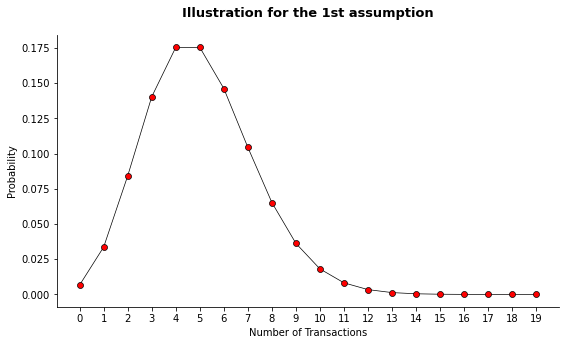

In [12]:
probability_arr = []
distribution = poisson(5)
for transactions in range(0, 20):
  probability_arr.append(distribution.pmf(transactions))

fig, ax = plt.subplots(figsize=(9, 5))
plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Illustration for the 1st assumption', fontweight='bold', fontsize=13, pad=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(probability_arr, color='black', linewidth=.7, zorder=1)
plt.scatter(range(0, 20), probability_arr, color='red', edgecolor='black', linewidth=.7, zorder=2)

* Differences in transaction rate between customers follows **a gamma distribution** with **shape r** and **scale α**



Text(0.5, 1.0, 'Illustration for the 2nd assumption')

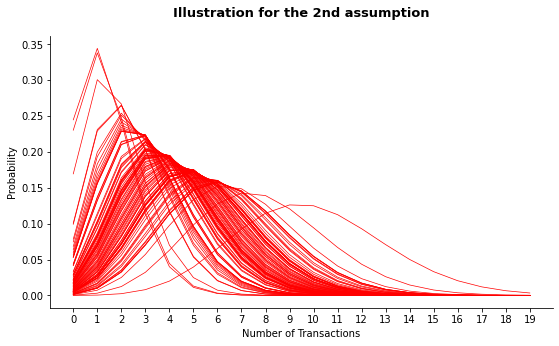

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))
for customer in range(0, 100):
  distribution = poisson(np.random.gamma(shape=9, scale=.5))
  probability_arr = []
  for transactions in range(0, 20):
    probability_arr.append(distribution.pmf(transactions))
  plt.plot(probability_arr, color='red', linewidth=0.7, zorder=1)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Illustration for the 2nd assumption', fontweight='bold', fontsize=13, pad=19)

* A customer may become inactive with **probability p** and turns away from the business. The churn risk follows a **Geometric distribution**.
* Differences in **p** follows a **Beta distribution** with **shape parameters a and b**

Text(0.5, 1.0, 'Probability Distribution Curve 100 Customers with drop-off probability after each transaction')

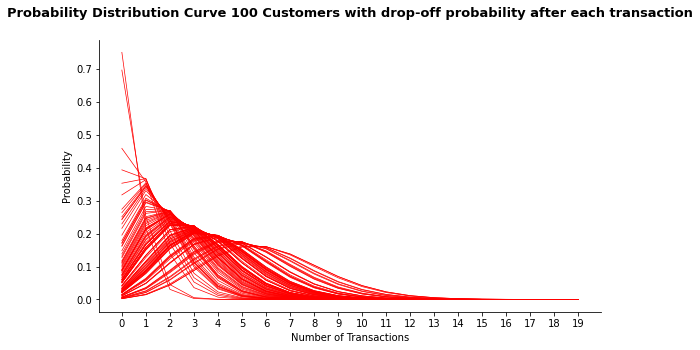

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
for customer in range(0, 100):
  distribution = poisson(np.random.gamma(shape=9, scale=.5))
  probability_arr = []
  beta = np.random.beta(a=1.0, b=2.5)
  cumulative_beta = 0
  for transactions in range(0, 20):
    proba = distribution.pmf(transactions)
    cumulative_beta = beta + cumulative_beta - (beta*cumulative_beta)
    inactive_probability = 1 - cumulative_beta
    proba *= inactive_probability
    probability_arr.append(proba)
  probability_arr = np.array(probability_arr)
  probability_arr /= probability_arr.sum()
  plt.plot(probability_arr, color='red', linewidth=.7, zorder=1)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve 100 Customers with drop-off probability after each transaction', fontweight='bold', pad=23, fontsize=13)

**3.1.2. Model Building**

In [44]:
today_date = dt.datetime(2022, 12, 10)
cltv_df = model.groupby('Customer ID').agg({'InvoiceDate': [lambda x: (x.max() - x.min()).days, lambda x: (today_date - x.min()).days],
                                        'Invoice': lambda x: x.nunique(),
                                        'Revenue': lambda x: x.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
# monetary should be the average value per purchase
cltv_df['monetary'] = cltv_df['monetary'] / cltv_df['frequency']
# frequency should be more than 1
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
# recency and T to be shown as weekly
cltv_df['recency'] = cltv_df['recency'] / 7
cltv_df['T'] = cltv_df['T'] / 7

cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,57.142857,677.571429,12,6463.038333
12347.0,57.428571,631.714286,8,704.165000
12348.0,51.714286,636.571429,5,403.880000
12349.0,81.428571,658.142857,4,1107.172500
12352.0,50.857143,630.000000,10,284.984000


In [45]:
bgf = BetaGeoFitter(penalizer_coef=.001)

bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

# 3-month expected number of purchases
cltv_df['expected_purc_12_week'] = bgf.predict(12, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'])

### **3.2. GAMMA-GAMMA**
**3.2.1. Concept**

The Gamma-Gamma model rests on the assumptions as follows:
* Customers differ in their average transaction values - some big spenders may have a propensity to spend twice as much per transaction as others
* Average monetary transaction value of an individual customer is time-invariant within the analytical horizon; the values of the customer’s transactions vary around the mean while the mean itself remains stable over time

In 1994, Schmittlein and Peterson proposed that the transaction values follow a normal distribution. But the normal distribution extends to negative infinity and is symmetric around its mean; whereas real-world frequency curves of spendings are non-negative and right-skewed. Then, Fader/Hardie suggested the Gamma distribution as a more appropriate alternative to mirror a customer’s average transaction value. They defined its scale parameter as a Gamma random variable of its own, therefore they labeled it Gamma-Gamma model.

Using Bayes’ theorem, they derived the conditional expectation of a customer’s mean transaction value. The more transactions have been observed, the less weight the model puts on the prior distribution and the more on the customer’s observed mean. The Gamma-Gamma model only works for positive monetary values. Thus, we exclude the few transactions with a unit price of zero.

**3.2.2. Model Building**

In [46]:
ggf = GammaGammaFitter(penalizer_coef=.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'], cltv_df['monetary'])

# Calculating CLTV by adding gg model
cltv = ggf.customer_lifetime_value(bgf, cltv_df['frequency'], cltv_df['recency'], cltv_df['T'], cltv_df['monetary'], time=3, freq="W", discount_rate=.01)
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(10)

,Customer ID,clv
2944,16446.0,0.692986
1512,14459.0,0.223431
132,12531.0,0.222268
26,12378.0,0.154979
2704,16127.0,0.096366
204,12638.0,0.077867
4046,17958.0,0.077196
1526,14474.0,0.073545
1989,15115.0,0.073084
870,13583.0,0.070092


In [47]:
cltv_final = cltv_df.merge(cltv, on='Customer ID', how='left')
cltv_final.sort_values(by='clv', ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_12_week,expected_average_profit,clv
2944,16446.0,29.142857,603.285714,2,84236.2500,0.000007,92282.275501,0.692986
1512,14459.0,70.857143,667.000000,2,2687.8705,0.000071,2946.588570,0.223431
132,12531.0,95.857143,672.000000,2,966.6000,0.000197,1060.948617,0.222268
26,12378.0,61.714286,654.285714,2,2708.1600,0.000049,2968.815578,0.154979
2704,16127.0,98.142857,677.714286,2,400.6550,0.000205,440.959775,0.096366
204,12638.0,86.571429,665.285714,2,460.7450,0.000144,506.787956,0.077867
4046,17958.0,87.285714,678.000000,2,486.9400,0.000135,535.484397,0.077196
1526,14474.0,76.142857,656.714286,2,639.0400,0.000098,702.108898,0.073545
1989,15115.0,102.000000,678.571429,2,265.9250,0.000234,293.363990,0.073084
870,13583.0,74.714286,671.000000,2,722.5155,0.000083,793.555732,0.070092
